# Deep-TICA: Neural network basis functions for TICA

Reference paper: _Bonati, Piccini and Parrinello, [PNAS](https://www.pnas.org/doi/10.1073/pnas.2113533118) (2020)_ [[arXiv]](https://arxiv.org/abs/2107.03943).

### Introduction

The aim of this tutorial is to illustrate how we can design collective variables as the slow modes of the system. We will cover both the unbiased case on the Muller-Brown potential, as well as the biased case with an OPES Multithermal simulation with alanine dipeptide. 

**Collective variables as slow modes**

In the framework of the Variational Approach to Conformation Dynamics (VAC), we can relate the eigenfunctions of the transfer operator (which evolves the probability density towards Boltzmann distribution) to the modes that relax more slowly towards the equilibrium. In a rare event scenario, these eigenfunctions are thus connected to the rare transitions between long-lived metastable states. To search for them, we can resort to a variational principle which tells us that these functions are characterized by the highest autocorrelation. Thus, they can be found with a statistical method called Time-lagged independent component analysis (TICA). 

TICA searches for the linear combinations of input features that are maximally autocorrelated and orthogonal to each other. This amounts to solving the following generalized eigenvalue problem:

$$ C(\tau) w_i = \lambda_i C(0) w_i$$

where $w_i$ are the eigenvectors associated to eigenvalues $\lambda_i$ and $C_{ij}(\tau)=<d_i(t)d_j(t+\tau)>$ is the time-correlation computed at lag-time $\tau$ between the descriptors.

**Deep TICA**

As in the DeepLDA tutorial, we can use a neural network to learn a feature map of the input into a latent space which allows maximizing the eigenvalues (i.e. the autocorrelation). As can be seen from the figure, the workflow is very similar to the previous DeepLDA method. What changes are the input data (here we need reactive trajectories) and the criterion used to train the NN (to maximize autocorrelation of the output variables rather than to separate the states). Indeed, the loss function here will be to maximize the squared sum of the eigenvalues of the TICA problem, applied to the outputs of the NN.

<center><img src="images/deeptica.png" width="600" /></center>

**Biased simulations**

These methods have been widely exploited to analyze long trajectories of biomolecular systems, made available for example by ad-hoc built computers. However, the main problem in the use of these methods is the need for data on the long-time dynamics of the system, which are rarely available. To overcome this obstacle, we can follow a two-step approach. A first exploratory enhanced sampling simulation is performed. This step does not necessarily require the use of a CV-based method and does not even need to be fully converged. It only needs to report on the transition pathways. Then, these enhanced sampling simulations are analyzed and their slow modes are extracted. 

To apply these methods not only to unbiased simulations but also to enhanced sampling we need to reweight the trajectory to account for the presence of the bias potential. This leads to considering an instantaneous acceleration of the timescales due to the bias potential. Note however that this requires some care from a numerical perspective, as we need to compute the correlation functions of an *exponentially* unevenly spaced time series.

An important point to note is the following: even when performing such reweighting, what we will learn are the slow modes of the biased dynamics towards the Boltzmann distribution. These might differ from the one of an unbiased simulation. For instance, if a variable has been accelerated by the addition of bias potential, the signal of such variable in the slow modes might be weaker. For these reasons, we recommend biasing these slow modes in addition to the previous bias potential. This can be also achieved by using a static bias obtained at the end of the first simulation, without the need of optimizing a multi-dimensional bias.

### Import

In [32]:
# IMPORT PACKAGES
import torch
import lightning
import numpy as np
import matplotlib.pyplot as plt

# IMPORT HELPER FUNCTIONS
from mlcolvar.utils.plot import muller_brown_potential, plot_isolines_2D, plot_metrics

# Set seed for reproducibility
torch.manual_seed(42)

## TICA & DeepTICA on Muller-Brown potential (high temperature MD)

### Load data

In [33]:
from mlcolvar.utils.io import load_dataframe
from mlcolvar.utils.timelagged import create_timelagged_dataset
from mlcolvar.data import DictModule

filenames = [ "data/muller-brown/unbiased/high-temp/COLVAR" ]

# load file
df = load_dataframe(filenames)

# get descriptors
X = df.filter(regex='p.x|p.y').values

# build time-lagged dataset (composed by pairs of configs at time t, t+lag)
dataset = create_timelagged_dataset(X,lag_time=1)

# create datamodule
datamodule = DictModule(dataset,lengths=[0.8,0.2])#,random_split=False,shuffle=False)

/home/lbonati@iit.local/work/code/mlcolvar/mlcolvar/utils/timelagged.py:129: UserWarning: Monitoring the progress for the search of time-lagged configurations with a progress_bar requires `tqdm`.
  warnings.warn('Monitoring the progress for the search of time-lagged configurations with a progress_bar requires `tqdm`.')


### TICA

### DeepTICA CV

#### Define model

In [34]:
from mlcolvar.cvs import DeepTICA

n_components = 2
nn_layers = [2, 15, 15, n_components]
options= {'nn': {'activation': 'shifted_softplus'}}

model = DeepTICA(nn_layers, options=options)
model

DeepTICA(
  (norm_in): Normalization(in_features=2, out_features=2, mode=mean_std)
  (nn): FeedForward(
    (nn): Sequential(
      (0): Linear(in_features=2, out_features=15, bias=True)
      (1): Shifted_Softplus(beta=1, threshold=20)
      (2): Linear(in_features=15, out_features=15, bias=True)
      (3): Shifted_Softplus(beta=1, threshold=20)
      (4): Linear(in_features=15, out_features=2, bias=True)
    )
  )
  (tica): TICA(in_features=2, out_features=2)
)

#### Define Trainer & Fit

In [35]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from mlcolvar.utils.trainer import MetricsCallback

# define callbacks
metrics = MetricsCallback()
early_stopping = EarlyStopping(monitor="valid_loss", min_delta=1e-5, patience=20)

# define trainer
trainer = lightning.Trainer(callbacks=[metrics, early_stopping],
                     max_epochs=None, logger=None, enable_checkpointing=False)

# fit
trainer.fit( model, datamodule )

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/lbonati@iit.local/software/anaconda3/envs/pytorch/lib/python3.10/site-packages/lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
/home/lbonati@iit.local/software/anaconda3/envs/pytorch/lib/python3.10/site-packages/lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(

  | Name    | Type          | Params | In sizes | Out sizes
-----------------------------------------------------------------
0 | norm_in | Normalization | 0      | [2]      | [2]      
1 | nn      | FeedForward   | 317    | [2]      | [2]      
2 | tica    | TICA          | 0      | [2]      | [2]      
-------------

Epoch 281: 100%|██████████| 2/2 [00:00<00:00, 132.90it/s, loss=-1.03]       


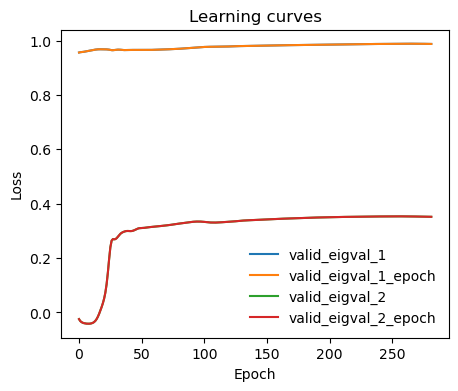

In [36]:
ax = plot_metrics(metrics.metrics, 
                  keys=[x for x in  metrics.metrics.keys() if 'valid_eigval' in x],#['train_loss_epoch','valid_loss'],
                  #linestyles=['-.','-'], colors=['fessa1','fessa5'],
                  yscale='linear')

#### Normalize output

In [37]:
from mlcolvar.core.transform import Normalization
from mlcolvar.core.transform.utils import Statistics

X = dataset[:]['data']
with torch.no_grad():
    model.postprocessing = None # reset  
    s = model(torch.Tensor(X))

norm =  Normalization(n_components, mode='min_max', stats = Statistics(s) ) 
model.postprocessing = norm
#print(Statistics(s))

#### Plot CVs isolines

Epoch 325:   0%|          | 0/2 [01:36<?, ?it/s, loss=-1.77]


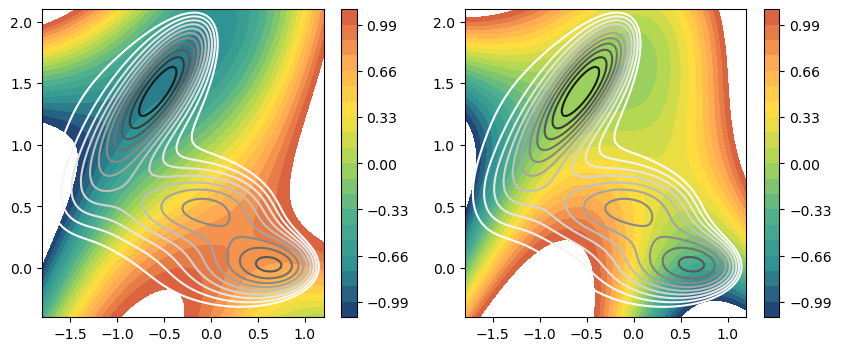

In [38]:
fig,axs = plt.subplots( 1, n_components, figsize=(5*n_components,4) )
if n_components == 1:
    axs = [axs]
for i in range(n_components):
    ax = axs[i]
    plot_isolines_2D(muller_brown_potential,levels=np.linspace(0,24,12),mode='contour',ax=ax)
    plot_isolines_2D(model, component=i, levels=np.linspace(-1.1,1.1,21), ax=ax)
    #plot_isolines_2D(model, component=i, mode='contour', levels=25, ax=ax)

#### Plot FES

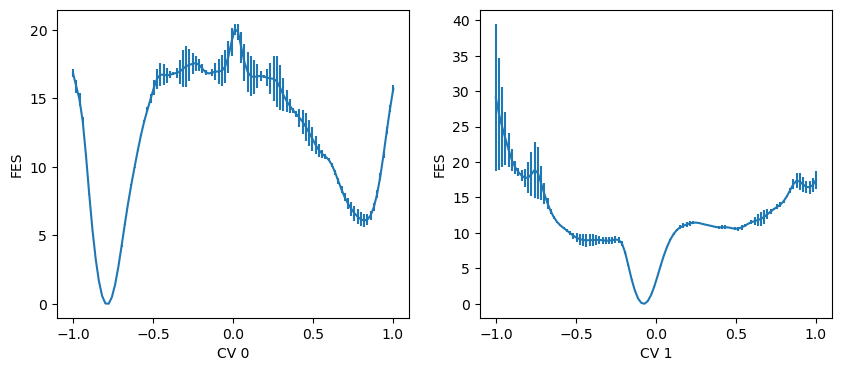

In [39]:
from mlcolvar.utils.fes import compute_fes

fig,axs = plt.subplots(1,n_components,figsize=(5*n_components,4))
if n_components == 1:
    axs = [axs]

X = dataset[:]['data']
model.eval()
with torch.no_grad():
    s = model(torch.Tensor(X)).numpy()

for i,ax in enumerate(axs):
    fes,grid,bounds,std = compute_fes(s[:,i], kbt=2.5, plot=True, scale_by='range', bandwidth=0.02, blocks=2, plot_max_fes=30, ax=ax )
    ax.set_xlabel(f'CV {i}')

## Biased data (OPES, CV = p.y)

### Load data

In [134]:
# modified potential with 3 states

def muller_brown_potential(x,y):
    prefactor = 0.15
    A=(-280,-170,-170,15)
    a=(-15,-1,-6.5,0.7)
    b=(0,0,11,0.6)
    c=(-10,-10,-6.5,0.7)
    x0=(1,0.2,-0.5,-1)
    y0=(0,0.5,1.5,1)
    offset = -146.7

    v = -prefactor*offset
    for i in range(4):
        v += prefactor * A[i]*np.exp( a[i]*(x-x0[i])**2 + b[i]*(x-x0[i])*(y-y0[i]) + c[i]*(y-y0[i])**2 )
    return v

In [145]:
from mlcolvar.utils.io import load_dataframe
from mlcolvar.utils.timelagged import create_timelagged_dataset
from mlcolvar.data import DictModule

filenames = [ "data/muller-brown-3states/biased/opes-y/COLVAR" ]

# load file
df = load_dataframe(filenames,start=5000,stride=1)

# get descriptors
X = df.filter(regex='p.x|p.y').values
t = df['time'].values

# get logweights for time rescaling
beta = 1
bias = df['opes.bias'].values
bias -= np.max(bias)
logweights = beta*bias
df['logweights'] = logweights

df

,time,p.x,p.y,p.z,ene,pot.bias,pot.ene_bias,opes.bias,opes.rct,opes.zed,opes.neff,opes.nker,lwall.bias,lwall.force2,uwall.bias,uwall.force2,walker,logweights
0,5000.0,0.951250,0.086911,0.0,1.691887,1.691887,1.691887,-8.561262,-0.201417,0.088927,1113.026053,60.0,0.0,0.0,0.0,0.0,0,-8.561262
1,5001.0,0.980493,-0.018727,0.0,1.045314,1.045314,1.045314,-7.851693,-0.201616,0.088927,1113.027733,60.0,0.0,0.0,0.0,0.0,0,-7.851693
2,5002.0,0.964506,-0.004901,0.0,0.487851,0.487851,0.487851,-7.537095,-0.201816,0.088928,1113.030033,60.0,0.0,0.0,0.0,0.0,0,-7.537095
3,5003.0,0.939127,0.192501,0.0,8.140130,8.140130,8.140130,-13.310998,-0.202016,0.088928,1113.030040,60.0,0.0,0.0,0.0,0.0,0,-13.310998
4,5004.0,1.003084,0.056576,0.0,1.854051,1.854051,1.854051,-7.662938,-0.202215,0.088928,1113.032069,60.0,0.0,0.0,0.0,0.0,0,-7.662938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14996,19996.0,0.931408,0.157108,0.0,5.785798,5.785798,5.785798,-6.746204,0.195680,0.112812,5987.807720,99.0,0.0,0.0,0.0,0.0,0,-6.746204
14997,19997.0,0.948995,-0.039593,0.0,1.752226,1.752226,1.752226,-3.053528,0.195645,0.112812,5987.983376,99.0,0.0,0.0,0.0,0.0,0,-3.053528
14998,19998.0,0.940675,-0.044266,0.0,2.155034,2.155034,2.155034,-3.230988,0.195608,0.112812,5988.131625,99.0,0.0,0.0,0.0,0.0,0,-3.230988
14999,19999.0,0.930904,0.153340,0.0,5.553812,5.553812,5.553812,-6.510059,0.195558,0.112812,5988.137424,99.0,0.0,0.0,0.0,0.0,0,-6.510059


<AxesSubplot:xlabel='p.x', ylabel='p.y'>

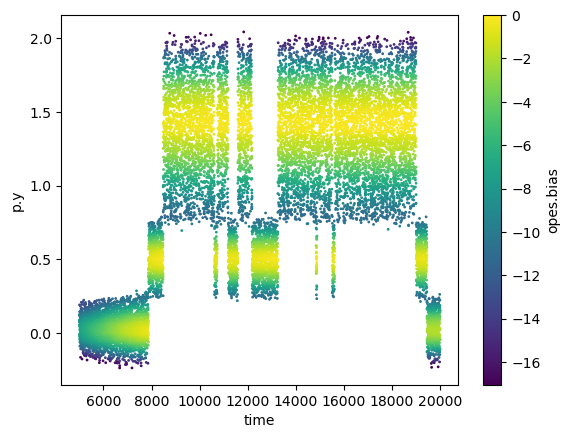

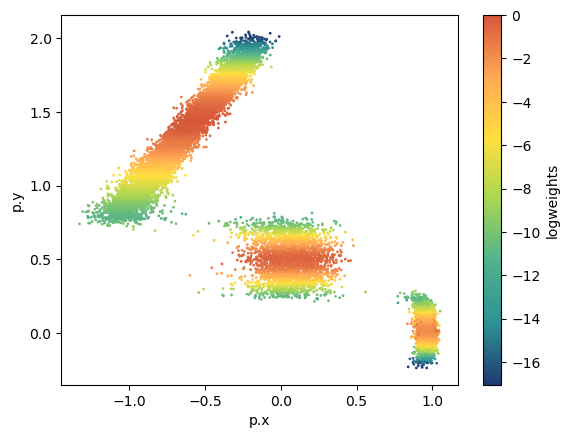

In [146]:
df.plot.scatter('time','p.y',c='opes.bias',s=1)
df.plot.scatter('p.x','p.y',c='logweights',s=1,cmap='fessa')

### Create time-lagged dataset

In [147]:
lag_time = 20

# build time-lagged dataset (composed by pairs of configs at time t, t+lag)
dataset = create_timelagged_dataset(X,t,lag_time=lag_time,logweights=logweights,progress_bar=True)

# create datamodule
datamodule = DictModule(dataset,lengths=[0.8,0.2],random_split=False,shuffle=False)

100%|██████████| 14964/14964 [00:06<00:00, 2385.45it/s]


### Define model

In [154]:
from mlcolvar.cvs import DeepTICA

n_components = 3
nn_layers = [2, 15, 15, n_components]
options= {'nn': {'activation': 'shifted_softplus'}}

model = DeepTICA(nn_layers, options=options)
model.loss_fn.mode = 'sum'
model

DeepTICA(
  (norm_in): Normalization(in_features=2, out_features=2, mode=mean_std)
  (nn): FeedForward(
    (nn): Sequential(
      (0): Linear(in_features=2, out_features=15, bias=True)
      (1): Shifted_Softplus(beta=1, threshold=20)
      (2): Linear(in_features=15, out_features=15, bias=True)
      (3): Shifted_Softplus(beta=1, threshold=20)
      (4): Linear(in_features=15, out_features=3, bias=True)
    )
  )
  (tica): TICA(in_features=3, out_features=3)
)

### Define Trainer & Fit

In [155]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from mlcolvar.utils.trainer import MetricsCallback

# define callbacks
metrics = MetricsCallback()
early_stopping = EarlyStopping(monitor="valid_loss", min_delta=1e-4, patience=20)

# define trainer
trainer = lightning.Trainer(callbacks=[metrics, early_stopping],
                     max_epochs=None, logger=None, enable_checkpointing=False)

# fit
trainer.fit( model, datamodule )

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/lbonati@iit.local/software/anaconda3/envs/pytorch/lib/python3.10/site-packages/lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
/home/lbonati@iit.local/software/anaconda3/envs/pytorch/lib/python3.10/site-packages/lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(

  | Name    | Type          | Params | In sizes | Out sizes
-----------------------------------------------------------------
0 | norm_in | Normalization | 0      | [2]      | [2]      
1 | nn      | FeedForward   | 333    | [2]      | [3]      
2 | tica    | TICA          | 0      | [3]      | [3]      
-------------

Epoch 999: 100%|██████████| 2/2 [00:00<00:00, 73.99it/s, loss=-1.85]        

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 2/2 [00:00<00:00, 71.26it/s, loss=-1.85]


### Plot metrics

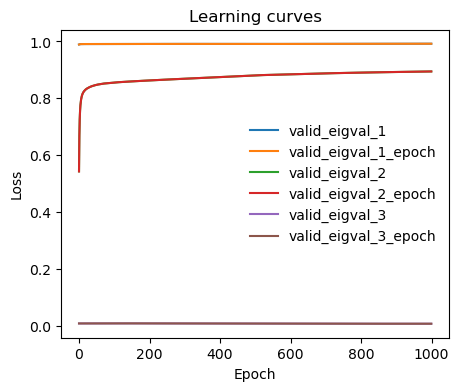

In [156]:
ax = plot_metrics(metrics.metrics, 
                  keys=[x for x in  metrics.metrics.keys() if 'valid_eigval' in x],#['train_loss_epoch','valid_loss'],
                  #linestyles=['-.','-'], colors=['fessa1','fessa5'],
                  yscale='linear')

### Normalize output

In [157]:
from mlcolvar.core.transform import Normalization
from mlcolvar.core.transform.utils import Statistics

X = dataset[:]['data']
with torch.no_grad():
    model.postprocessing = None # reset  
    s = model(torch.Tensor(X))

norm =  Normalization(n_components, mode='min_max', stats = Statistics(s) ) 
model.postprocessing = norm
#print(Statistics(s))

### Plot CVs isolines

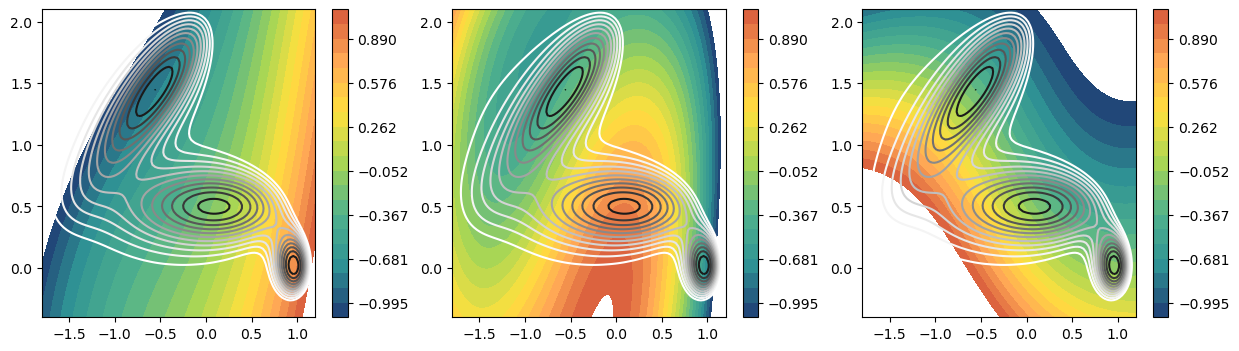

In [158]:
fig,axs = plt.subplots( 1, n_components, figsize=(5*n_components,4) )
if n_components == 1:
    axs = [axs]
for i in range(n_components):
    ax = axs[i]
    plot_isolines_2D(muller_brown_potential,levels=np.linspace(0,24,12),mode='contour',ax=ax)
    plot_isolines_2D(model, component=i, levels=np.linspace(-1.1,1.1,22), ax=ax)
    #plot_isolines_2D(model, component=i, mode='contour', levels=25, ax=ax)